# Golf Clubs and how the Magnus Effect influence them
Authors: Justin Riccardelli, Timothy Beal

Using data already gathered on average ball speed, launch angle and spin rate, we can calculate an approximate distance with each club assuming that each ball is hit perfectly. Using this, we will calculate each club (3-iron through pitching wedge) hit with and without magnus effect in order to determine which clubs distance is most affected by backspin. Our conclusion will be based off the percentage lost, not distance lost as we can assume the greatest amount of distance lost will be the club that goes the farthest. Yards is commonly used for golf to we will be showing both the distance in meters and in yards.

Our Drag Coefficient for our golfball is based off this article on a titleist golf ball.

https://www.scirp.org/journal/paperinformation.aspx?paperid=85529#


The data for each club is the following (gathered from trackman, the best golf simulator today):

![pgatourstats.png](pgatourstats.png)

## The Magnus Effect

The Magnus Effect is the force applied to a ball due to its interaction with the air and the spin of the ball. The spinning ball applies a force to the air, which applies an equal an opposite force back to the ball according to Newtons 3rd law. For example, a ball with backspin pushes the air down as it travels over the top surface of the ball, which causes the air to apply a force upward giving the ball lift.

The equation we use for Magnus Effect is: $$\vec{F}_{magnus} = \alpha \vec{\omega} \times \vec{v}$$

Our variable $\alpha$ in the equation above is a constant based off of the air and ball properties. It does not effect the velocity of the ball as the force it applies is perpendicular to the velocity.

To give us an applicable equation where we use variables to find $\alpha$, we can rewrite the Magnus Effect as: $$\vec{F}_{magnus} = \frac{1}{2}C_L \frac{\rho A r}{S} \vec{\omega} \times \vec{v}$$

$C_L$ is our lift coefficient depends which is based on the spin of the ball ($S = \frac{r\omega}{v}$) and is found using a curve fit.

$$C_L = 0.62S^{0.7}$$

Other variables in Magnus are:
* $\rho$ (rho) which is a constant
* A which is cross sectional area of the ball
* r which is the radius of the ball

$\vec{\omega}$ is our angular velocity of the ball and $\vec{v}$ is our velocity of the ball

Our simulation assumes that the golf ball is hit from a stationary position with a $+x$ velocity toward the green and a $+y$ velocity up. As per usual with golf, the ball is hit with backspin, which gives our angular velocity a $+z$ direction. 

$$\vec{v} = \langle v_x, v_y, 0 \rangle$$

$$\vec{\omega} = \langle 0, 0, \omega \rangle$$



# The Code Begins...

Below is code for the basic setup and variables

In [1]:
import ode #ode.py should be in the same folder as your notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#parameters
g = 9.8 #N/kg
rho = 1.2 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 74e-3/2 #74 mm diameter, 9.25" in circumference
A = np.pi*r**2 #cross-sectional area
Cd = 0.5 #actually depends on speed
m = 0.145 #kg
b2 = 1/2*Cd*rho*A #will change as Cd changes

S = 0.01 #will change as omega and v change
CL = 0 #will change with S
alpha = 1/2*CL*rho*A*r/S

#### We define our initial conditions of the golf ball by using a function called initial()

In [3]:
def initial(speed,deg,rpm):
    # data for golf club
    global omegamag,omegax,omegay,omegaz
    vmag0mph = speed #mph
    thetadeg = deg #deg
    spinrate = rpm #rpm

    # convert units and create initial conditions
    vmag0 = vmag0mph*0.44704 #convert mph to m/s
    theta = thetadeg*np.pi/180 #convert deg to rad

    # initial position and velocity components
    x = 0
    y = 0
    z = 0
    vx = vmag0*np.cos(theta)
    vy = vmag0*np.sin(theta)
    vz = 0

    # initial angular speed and velocity
    omegamag = spinrate * 2*np.pi / 60 #convert to rad/s
    omegax = 0
    omegay = 0
    omegaz = omegamag
    
    array = np.array([x,y,z,vx,vy,vz,omegamag,omegax,omegay,omegaz])
    return array

#### Below is the Magnus function

In [35]:
def magnus(d, t):
    """ Calculate and return the derivative of each quantity in an array d at the time t.
    
    Keyword arguments:
    t -- time at the beginning of the time step
    d -- an array of variables at time t
    """
    
    x = d[0]
    y = d[1]
    z = d[2]
    vx = d[3]
    vy = d[4]
    vz = d[5]
    
    dxdt = vx
    dydt = vy
    dzdt = vz

    
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    Cd = .4
    
    b2 = 1/2*Cd*rho*A
    Fdragx = -b2*v**2*vx/v
    Fdragy = -b2*v**2*vy/v
    Fdragz = -b2*v**2*vz/v
    
    #magnus
    S = r*omegamag/v
    CL = 0.62*S**0.7
    alpha = 1/2*CL*rho*A*r/S
    Fmagnusx = alpha*(omegay*vz - omegaz*vy)
    Fmagnusy = alpha*(omegaz*vx - omegax*vz)
    Fmagnusz = alpha*(omegax*vy - omegay*vx)
    
    #grav
    Fgravy = -m*g
    
    #Fnet
    Fnetx = Fdragx + Fmagnusx
    Fnety = Fdragy + Fmagnusy + Fgravy
    Fnetz = Fdragz + Fmagnusz
    
    #derivative of velocity
    dvxdt = Fnetx/m
    dvydt = Fnety/m
    dvzdt = Fnetz/m
    
    derivs = np.array([dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt])
    
    return derivs


#### Below we define our function only using drag with no magnus effect

In [38]:
def nonmagnus(d, t):
    """ Calculate and return the derivative of each quantity in an array d at the time t.
    
    Keyword arguments:
    t -- time at the beginning of the time step
    d -- an array of variables at time t
    """
    
    x = d[0]
    y = d[1]
    z = d[2]
    vx = d[3]
    vy = d[4]
    vz = d[5]
    
    dxdt = vx
    dydt = vy
    dzdt = vz

    
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    cd = .4
    
    b2 = 1/2*Cd*rho*A
    Fdragx = -b2*v**2*vx/v
    Fdragy = -b2*v**2*vy/v
    Fdragz = -b2*v**2*vz/v
    
    
    #grav
    Fgravy = -m*g
    
    #Fnet
    Fnetx = Fdragx
    Fnety = Fdragy + Fgravy
    Fnetz = Fdragz
    
    #derivative of velocity
    dvxdt = Fnetx/m
    dvydt = Fnety/m
    dvzdt = Fnetz/m
    
    derivs = np.array([dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt])
    
    return derivs


#### Below is the function for running the simulation and outputting the graphs

In [39]:
def run(array):
    t = 0
    h = 0.01
    
    x = array[0]
    y = array[1]
    z = array[2]
    vx = array[3]
    vy = array[4]
    vz = array[5]
    omegamag = array[6]
    omegax = array[7]
    omegay = array[8]
    omegaz = array[9]

    # array for instantaneous position and velocity data
    data = np.array([x, y, z, vx, vy, vz])


    # lists for storing data to graph
    tlist = []
    xlist = []
    ylist = []

    # store initial values
    tlist.append(t)
    xlist.append(x)
    ylist.append(y)

    while y >= 0:

        data = ode.RK4(magnus, data, t, h)
        t = t + h

        x = data[0]
        y = data[1]

        tlist.append(t)
        xlist.append(x)
        ylist.append(y)

    xmax = xlist[-1]
    print("max x in m = ", xmax)

    xmax_yd = xmax*1.094
    print("max x in yd = ", xmax_yd)
    
    return xlist,ylist,xmax_yd

#### Run code used with no Magnus Effect

In [40]:
def nrun(array):
    t = 0
    h = 0.01
    
    x = array[0]
    y = array[1]
    z = array[2]
    vx = array[3]
    vy = array[4]
    vz = array[5]
    omegamag = array[6]
    omegax = array[7]
    omegay = array[8]
    omegaz = array[9]

    # array for instantaneous position and velocity data
    data = np.array([x, y, z, vx, vy, vz])


    # lists for storing data to graph
    tlist = []
    xlist = []
    ylist = []

    # store initial values
    tlist.append(t)
    xlist.append(x)
    ylist.append(y)

    while y >= 0:

        data = ode.RK4(nonmagnus, data, t, h)
        t = t + h

        x = data[0]
        y = data[1]

        tlist.append(t)
        xlist.append(x)
        ylist.append(y)

    xmax = xlist[-1]
    print("max x in m = ", xmax)

    nxmax_yd = xmax*1.094
    print("max x in yd = ", nxmax_yd)
    
    return xlist,ylist,nxmax_yd

#### Functions to plot and calculate percentage lost

In [41]:
def plot(xlist,ylist):
    plt.figure(figsize = (8,6))
    plt.title("Trajectory of the Golf Ball")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.plot(xlist, ylist)
    plt.show()
    
def plost(xmax_yd,nxmax_yd):
    plost = ((xmax_yd - nxmax_yd)/xmax_yd)*100
    print("Percentage lost = ", plost,"%")

# Testing each club
Having our code set up prior, we will run each club with our code and determine which clubs distance is most effected by the Magnus Effect.

To see the graph, just uncomment the plot() function for whichever instance you would like to see. We will show both graphs for the 3 iron to see what each graph should approximately look like.

#### 3 iron with Magnus Effect

max x in m =  182.50954415610153
max x in yd =  199.66544130677508


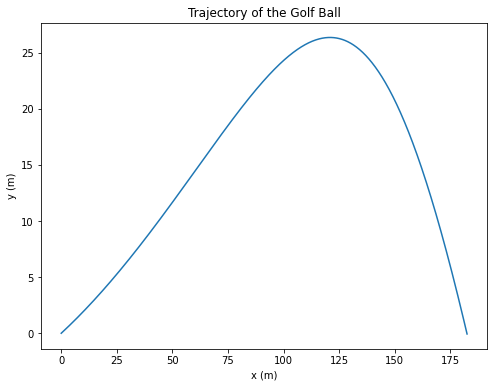

In [42]:
output = initial(142,10.4,4630)
xlist,ylist,x = run(output)
plot(xlist,ylist)

#### 3 Iron without Magnus Effect

max x in m =  83.20413830662953
max x in yd =  91.02532730745271


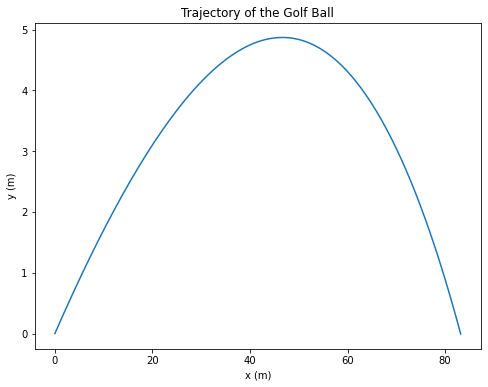

Percentage lost =  54.41107549122772 %


In [43]:
output = initial(142,10.4,4630)
xlist,ylist,y = nrun(output)
plot(xlist,ylist)
plost(x,y)

#### 4 Iron with Magnus Effect

In [44]:
output = initial(137,11,4836)
xlist,ylist,x = run(output)
#plot(xlist,ylist)

max x in m =  178.48827003791416
max x in yd =  195.26616742147812


#### 4 Iron without Magnus Effect

In [45]:
output = initial(142,10.4,4630)
xlist,ylist,y = nrun(output)
#plot(xlist,ylist)
plost(x,y)

max x in m =  83.20413830662953
max x in yd =  91.02532730745271
Percentage lost =  53.38397403428502 %


#### 5 Iron with Magnus Effect

In [46]:
output = initial(132,12.1,5361)
xlist,ylist,x = run(output)
#plot(xlist,ylist)

max x in m =  176.03791666345336
max x in yd =  192.58548082981798


#### 5 Iron without Magnus Effect

In [47]:
output = initial(132,12.1,5361)
xlist,ylist,y = nrun(output)
#plot(xlist,ylist)
plost(x,y)

max x in m =  83.0684883542187
max x in yd =  90.87692625951527
Percentage lost =  52.812161193075355 %


#### 6 Iron with Magnus Effect

In [48]:
output = initial(127,14.1,6231)
xlist,ylist,x = run(output)
#plot(xlist,ylist)

max x in m =  172.87249494148946
max x in yd =  189.12250946598948


#### 6 Iron without Magnus Effect

In [49]:
output = initial(127,14.1,6231)
xlist,ylist,y = nrun(output)
#plot(xlist,ylist)
plost(x,y)

max x in m =  86.25103939305596
max x in yd =  94.35863709600324
Percentage lost =  50.10713565379585 %


#### 7 Iron with Magnus Effect

In [50]:
output = initial(120,16.3,7097)
xlist,ylist,x = run(output)
#plot(xlist,ylist)

max x in m =  163.88619898236934
max x in yd =  179.29150168671208


#### 7 Iron without Magnus Effect

In [51]:
output = initial(120,16.3,7097)
xlist,ylist,y = nrun(output)
#plot(xlist,ylist)
plost(x,y)

max x in m =  86.9577109383094
max x in yd =  95.1317357665105
Percentage lost =  46.94018686243117 %


#### 8 Iron with Magnus Effect

In [52]:
output = initial(115,18.1,7998)
xlist,ylist,x = run(output)
#plot(xlist,ylist)

max x in m =  155.47719974122467
max x in yd =  170.0920565168998


#### 8 Iron without Magnus Effect

In [53]:
output = initial(115,18.1,7998)
xlist,ylist,y = nrun(output)
#plot(xlist,ylist)
plost(x,y)

max x in m =  87.10408236036164
max x in yd =  95.29186610223564
Percentage lost =  43.976298450617094 %


#### 9 Iron with Magnus Effect

In [54]:
output = initial(109,20.4,8647)
xlist,ylist,x = run(output)
#plot(xlist,ylist)

max x in m =  144.60398914967283
max x in yd =  158.1967641297421


#### 9 Iron without Magnus Effect

In [55]:
output = initial(109,20.4,8647)
xlist,ylist,y = nrun(output)
#plot(xlist,ylist)
plost(x,y)

max x in m =  86.71678410187535
max x in yd =  94.86816180745164
Percentage lost =  40.03154089191906 %


#### Pitching Wedge with Magnus Effect

In [56]:
output = initial(102,24.2,9304)
xlist,ylist,x = run(output)
#plot(xlist,ylist)

max x in m =  129.42544626669707
max x in yd =  141.5914382157666


#### Pitching Wedge without Magnus Effect

In [57]:
output = initial(102,24.2,9304)
xlist,ylist,y = nrun(output)
#plot(xlist,ylist)
plost(x,y)

max x in m =  86.28590295485877
max x in yd =  94.3967778326155
Percentage lost =  33.3315777972625 %


## Results

As we go through each instance, we see a decrease in percentage lost from the 3 iron to the pitching wedge, so the club most effected by the Magnus Effect is the 3 iron. Based on our results, we can conclude that even tho the high numbered irons have a much higher spin rate, the speed of the ball is really what determines how much the distance is effected for each club. This also can be important while playing golf, as it shows that lower lofted clubs are more affected by spin. This shows how it is more important to not hook or slice the ball with those clubs at it will have a greater error effect on your shot compared to the higher lofted clubs.

Our results also show the effect on the game of golf itself the Magnus Effect has. Holes in golf can range up to almost 600 yards. Without being able to have golf clubs that can reach into the 200 yard range, golf would be a dramatically different sport that it is now.